# Модели МО для отбора коров для молочного хозяйства «Вольный луг»

К нам обратился фермер, владелец молочного хозяйства «Вольный луг». Он хочет расширить поголовье стада коров, для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая корова давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям.
Поэтому он просит разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Нам нужно создать две прогнозные модели для отбора коров в поголовье:
1. Первая будет прогнозировать возможный удой коровы (целевой признак "Удой");
2. Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак "Вкус молока").

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.


<a id='К-содержанию'></a>
**Содержание проекта** \
[Загрузка данных](#Загрузка-данных)\
[Предобработка данных](#Предобработка-данных)\
[Исследовательский анализ данных](#Исследовательский-анализ-данных)\
[Корреляционный анализ](#Корреляционный-анализ)\
[Обучение модели линейной регрессии](#Обучение-модели-линейной-регрессии)\
[Обучение модели логистической регрессии](#Обучение-модели-логистической-регрессии)\
[Итоговые выводы](#Итоговые-выводы)

In [1]:
#импортируем библиотеки перед началом проекта одним блоком
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_error, confusion_matrix, recall_score, precision_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import precision_recall_curve

try:
    from sklearn.metrics import root_mean_squared_error, mean_squared_error
except:
    from sklearn.metrics import mean_squared_error
    

## Загрузка данных 
<a id='Загрузка-данных'></a> [К содержанию](#К-содержанию) 

In [2]:
#зададим стандарт датафрейма перед загрузкой
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.3f}'.format)

#импортируем данные
try:
    ferma = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_6_Korovy/ferma_main.csv', sep=';',decimal=',')
    ferma_dad = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_6_Korovy/ferma_dad.csv', sep=';',decimal=',') 
    cows = pd.read_csv('/Users/roman_yakovlev/Downloads/Практикум_DS/Проекты/Project_6_Korovy/cow_buy.csv', sep=';',decimal=',')    
except:
    ferma = pd.read_csv('/datasets/ferma_main.csv', sep=';',decimal=',')
    ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';',decimal=',')
    cows = pd.read_csv('/datasets/cow_buy.csv', sep=';',decimal=',')
    
#выводим информацию по структуре и данным по каждому датафрейму
def get_info(dataset):
    display(dataset.info(), dataset.head(5), dataset.tail(5))

        
get_info(ferma)
get_info(ferma_dad)
get_info(cows);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

None

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.200,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.580,3.076,вкусно,более_2_лет
1,2,5529,12.800,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.540,3.079,вкусно,менее_2_лет
2,3,5810,14.000,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.590,3.074,не вкусно,более_2_лет
3,4,5895,12.400,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.400,3.075,не вкусно,более_2_лет
4,5,5302,12.800,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.730,3.073,вкусно,менее_2_лет


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
629,627,5970,14.400,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.640,3.075,не вкусно,более_2_лет
630,627,5970,14.400,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.640,3.075,не вкусно,более_2_лет
631,627,5970,14.400,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.640,3.075,не вкусно,более_2_лет
632,627,5970,14.400,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.640,3.075,не вкусно,более_2_лет
633,627,5970,14.400,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.640,3.075,не вкусно,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


,id,Имя Папы
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин
628,629,Соловчик


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


None

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.580,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.540,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.590,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.400,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.640,3.074,более_2_лет


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
15,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.400,3.065,более_2_лет
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.730,3.079,более_2_лет
17,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.770,3.053,менее_2_лет
18,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.340,3.069,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.640,3.074,более_2_лет


**Вывод**

По предварительной оценке загруженных данных видна необходимость (1)корректировки названий столбцов и текстовых параметров (для проверки на дубликаты), (2) приведения типов данных к корректным для удобного анализа, (3) проверки исходных данных на пропуски и дубликаты для последующего устранения.

## Предобработка данных
<a id='Предобработка-данных'></a> [К содержанию](#К-содержанию) 

По очереди рассмотрим и скорректируем(при необходимости) все вышеобозначенные замечания из вывода предыдущего раздела:

In [3]:
# переименуем столбцы в более короткие английские названия в нижнем регистре и без пробелов
# для этого создадим словарь названий
columns_names = {'Удой, кг':'milk_yield',
                'ЭКЕ (Энергетическая кормовая единица)':'efu',
                'Сырой протеин, г':'crude_protein',
                'СПО (Сахаро-протеиновое соотношение)':'spr',
                'Порода':'breed',
                'Тип пастбища':'pasture',
                'порода папы_быка':'dad_breed',
                'Жирность,%':'fat',
                'Белок,%':'protein',
                'Вкус молока':'taste',
                'Возраст':'age',
                'Текущая_жирность,%':'fat',
                'Текущий_уровень_белок,%':'protein',
                'Имя_папы':'dad_name',
                'Имя Папы':'dad_name'}

ferma = ferma.rename(columns=columns_names)
ferma_dad = ferma_dad.rename(columns=columns_names)
cows = cows.rename(columns=columns_names)

#проверим названия после переименования
display(ferma.head(2),
        ferma_dad.head(2),
        cows.head(2))

,id,milk_yield,efu,crude_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age
0,1,5863,14.200,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.580,3.076,вкусно,более_2_лет
1,2,5529,12.800,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.540,3.079,вкусно,менее_2_лет


,id,dad_name
0,1,Буйный
1,2,Соловчик


,breed,pasture,dad_breed,dad_name,fat,protein,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.580,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.540,3.081,менее_2_лет


In [4]:
#приведем все значения к нижнему регистру
ferma = ferma.apply(lambda x: x.astype(str).str.lower())
ferma_dad = ferma_dad.apply(lambda x: x.astype(str).str.lower())
cows = cows.apply(lambda x: x.astype(str).str.lower())

#заменим пробелы на '_'
def replace_spaces(s):
    return s.replace(" ", "_")

ferma['breed'] = ferma['breed'].apply(replace_spaces)
cows['breed'] = cows['breed'].apply(replace_spaces)

display(ferma.head(2), cows.head(2))

,id,milk_yield,efu,crude_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age
0,1,5863,14.2,1743,0.89,вис_бик_айдиал,равнинное,айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.89,вис_бик_айдиал,равнинные,соверин,3.54,3.079,вкусно,менее_2_лет


,breed,pasture,dad_breed,dad_name,fat,protein,age
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет
1,вис_бик_айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет


In [5]:
#проверим значения в столбцах на неявные дубликаты
ferma_columns_category = ['breed','pasture','dad_breed','taste','age']
cows_columns_category = ['breed','pasture','dad_breed','dad_name','age']

def unique_names(df,columns):
    for column in columns:
        unique_values = df[column].unique()
        print(f'Уникальные значения в столбце {column}: {unique_values}')

print('Для таблицы ferma:') 
unique_names(ferma,ferma_columns_category);

print('\nДля таблицы cows:') 
unique_names(cows,cows_columns_category);

print('\nДля таблицы ferma_dad:') 
print(f'Уникальные значения в столбце dad_name: {ferma_dad["dad_name"].unique()}')


Для таблицы ferma:
Уникальные значения в столбце breed: ['вис_бик_айдиал' 'рефлешнсоверинг']
Уникальные значения в столбце pasture: ['равнинное' 'равнинные' 'холмистое']
Уникальные значения в столбце dad_breed: ['айдиал' 'соверин' 'айдиалл']
Уникальные значения в столбце taste: ['вкусно' 'не вкусно']
Уникальные значения в столбце age: ['более_2_лет' 'менее_2_лет']

Для таблицы cows:
Уникальные значения в столбце breed: ['вис_бик_айдиал' 'рефлешнсоверинг']
Уникальные значения в столбце pasture: ['холмистое' 'равнинное']
Уникальные значения в столбце dad_breed: ['айдиал' 'соверин']
Уникальные значения в столбце dad_name: ['геркулес' 'буйный' 'барин' 'соловчик']
Уникальные значения в столбце age: ['более_2_лет' 'менее_2_лет']

Для таблицы ferma_dad:
Уникальные значения в столбце dad_name: ['буйный' 'соловчик' 'барин' 'геркулес']


In [6]:
#заменим похожие названия на единый аналог
ferma['pasture'] = ferma['pasture'].replace('равнинные', 'равнинное')
ferma['dad_breed'] = ferma['dad_breed'].replace('айдиалл', 'айдиал')


In [7]:
#скорректируем типы данным по столбцам всех таблиц
ferma[['id','milk_yield', 'crude_protein']] = ferma[['id','milk_yield', 'crude_protein']].astype(np.int32)
ferma.replace(',', '.', regex=True, inplace=True)
ferma[['efu','spr','fat','protein']] = ferma[['efu','spr','fat','protein']].astype(np.float32)

cows.replace(',', '.', regex=True, inplace=True)
cows[['fat','protein']] = ferma[['fat','protein']].astype(np.float32)

ferma_dad['id'] = ferma_dad['id'].astype(np.int32)

cows.info()
ferma.info()
ferma_dad.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   breed      20 non-null     object 
 1   pasture    20 non-null     object 
 2   dad_breed  20 non-null     object 
 3   dad_name   20 non-null     object 
 4   fat        20 non-null     float32
 5   protein    20 non-null     float32
 6   age        20 non-null     object 
dtypes: float32(2), object(5)
memory usage: 1.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             634 non-null    int32  
 1   milk_yield     634 non-null    int32  
 2   efu            634 non-null    float32
 3   crude_protein  634 non-null    int32  
 4   spr            634 non-null    float32
 5   breed          634 non-null    object 
 6   pasture        634 non-n

In [8]:
#проверим пропуски
print(f'Количество пропусков по таблицу ferma: {ferma.isna().sum()}')
print(f'Количество пропусков по таблицу ferma_dad: {ferma_dad.isna().sum()}')
print(f'Количество пропусков по таблицу cows: {cows.isna().sum()}')

Количество пропусков по таблицу ferma: id               0
milk_yield       0
efu              0
crude_protein    0
spr              0
breed            0
pasture          0
dad_breed        0
fat              0
protein          0
taste            0
age              0
dtype: int64
Количество пропусков по таблицу ferma_dad: id          0
dad_name    0
dtype: int64
Количество пропусков по таблицу cows: breed        0
pasture      0
dad_breed    0
dad_name     0
fat          0
protein      0
age          0
dtype: int64


In [9]:
#проверим и уберем дубликаты
display(ferma.duplicated().sum())
display(ferma_dad.duplicated().sum())
display(cows.duplicated().sum())

ferma = ferma.drop_duplicates()


5

0

0

**Вывод**

В рамках предобработки были внесены следующие правки:

- названия столбцов изменены на более лаконичные английские в строчном размере;
- в текстовых данных по всем трем таблицам пробелы заменены на знаки подчеркивания, выявлены и заменены неявные дубликаты, данные также переведены к строчному размеру;
- в числовых данных разделитель целой и дробной части заменен на точку и числовые данные приведены к типам int32 и float32 по неоходимости;
- в таблице ferma (данные о текущем стаде заказчика) выявлены и исключены дубликаты.

Некоторые параметры в таблицах бинарны, например, "порода", "пастбище", "вкус", "возраст" для наглядности и исследовательского анализа оставим эти данные в текущем виде, в дальнейшем на стадии подготовки данных для обучения моделей эти признаки можно будет закодировать бинарными категориями "1" и "0".

## Исследовательский анализ данных
<a id='Исследовательский-анализ-данных'></a> [К содержанию](#К-содержанию) 

Сначала посмотрим на стандартные статистики по таблицам и распределения данных:

,id,milk_yield,efu,crude_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age
0,1,5863,14.200,1743,0.890,вис_бик_айдиал,равнинное,айдиал,3.580,3.076,вкусно,более_2_лет
1,2,5529,12.800,2138,0.890,вис_бик_айдиал,равнинное,соверин,3.540,3.079,вкусно,менее_2_лет


,id,milk_yield,efu,crude_protein,spr,fat,protein
count,629.000,629.000,629.000,629.000,629.000,629.000,629.000
mean,315.000,6188.750,14.544,1923.364,0.913,3.604,3.076
std,181.721,1644.795,1.306,182.956,0.032,0.169,0.003
min,1.000,5204.000,10.900,1660.000,0.840,2.990,3.069
25%,158.000,5751.000,13.500,1771.000,0.890,3.590,3.074
50%,315.000,6133.000,14.700,1888.000,0.930,3.650,3.076
75%,472.000,6501.000,15.600,2062.000,0.940,3.720,3.077
max,629.000,45616.000,16.800,2349.000,0.960,3.750,3.085


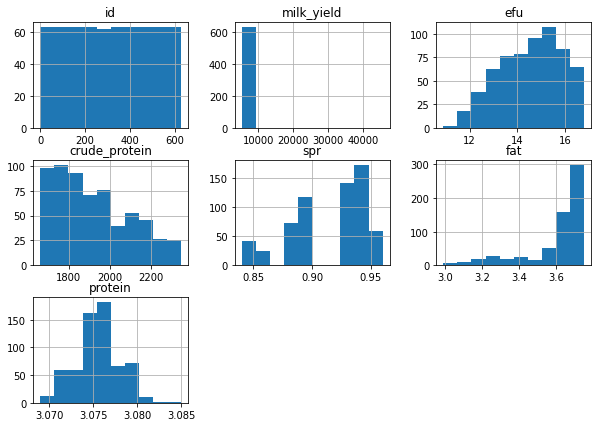

In [10]:
display(ferma.head(2))

#посмотрим на распределение данных в целом по таблице ferma
ferma.hist(figsize=(10, 7));
display(ferma.describe())


В таблице ferma по признаку удоя (milk_yield) есть выброс который надо обработать, по остальным числовым признакам 'efu', 'crude_protein', 'spr', 'fat' распределения данных ассиметричны, но выбросов не наблюдается, посмотрим на них отдельно и заодно на категориальные признаки.

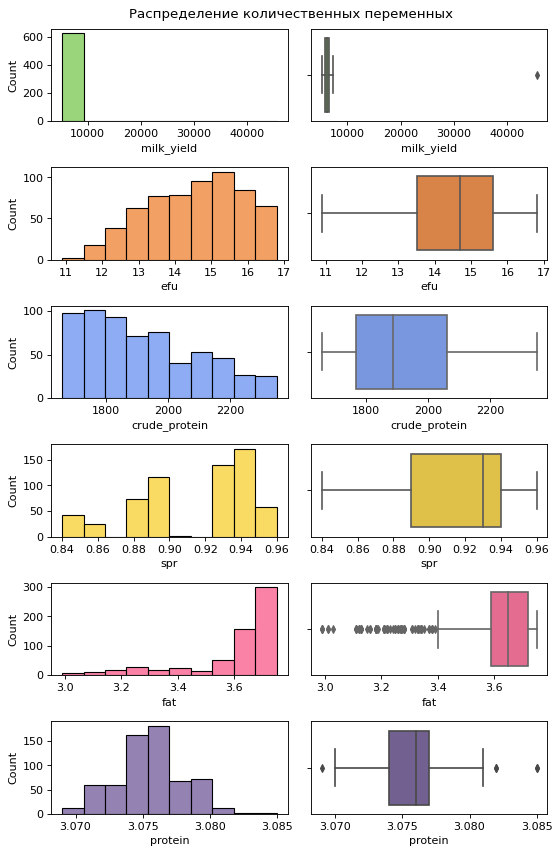

In [11]:
#построим отдельно графики гистограммы и "ящик с усами" для количественных признаков

plt.figure(figsize=[8, 13], dpi=80)
plt.subplots_adjust(wspace=0.1, hspace=0.5)
plt.suptitle('Распределение количественных переменных', y=0.9)
colors = ['#78C850', '#F08030', '#6890F0','#F8D030', '#F85888', '#705898', '#98D8D8']

columns_num = ['milk_yield','efu','crude_protein','spr','fat','protein']

for index, column in enumerate(columns_num):  
    
    plt.subplot(6, 2, index*2+1)
    sns.histplot(ferma[column], bins=10, color=colors[index])
    
    
    plt.subplot(6, 2, index*2+2)
    sns.boxplot(x=ferma[column], color=colors[index])


In [12]:
#посмотрим как много выбросов по переменной Удой (milk_yield) более 10000 кг молока в год
ferma[ferma['milk_yield']>10000]


,id,milk_yield,efu,crude_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age
16,17,45616,11.500,1675,0.930,вис_бик_айдиал,холмистое,айдиал,3.220,3.076,вкусно,более_2_лет


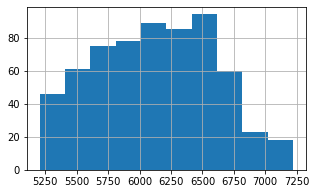

In [13]:
#это явно ошибка в данных, заменим на среднее без учета выброса
ferma.loc[16,'milk_yield'] = round(ferma[ferma['milk_yield']<10000]['milk_yield'].mean())

ferma['milk_yield'].hist(figsize=(5, 3));

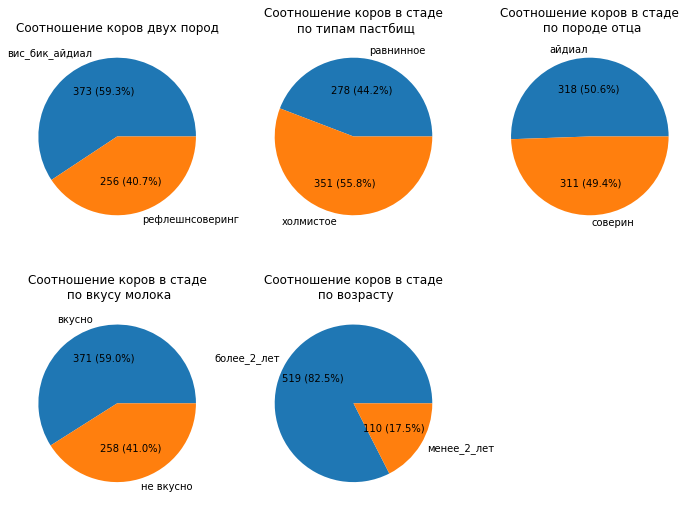

In [14]:
#построим графики типа pie по категориальным данным

#функция подсчета абсолютных значений для указания на диаграмме
def absolute_value(val,df):
    a = round(val/100.*df.sum())
    return a

plt.figure(figsize=[12, 9])

plt.subplot(2,3,1)
ferma_grouped = ferma.groupby('breed')['breed'].count()
ferma.groupby('breed')['breed'].count().plot(kind='pie', 
             title ='Cоотношение коров двух пород',
             radius=1,
             ylabel='',
             autopct=lambda x: f'{absolute_value(x, ferma_grouped)} ({x:.1f}%)');
#plt.legend(title="Порода", loc="best");

plt.subplot(2,3,2)
ferma_grouped = ferma.groupby('pasture')['pasture'].count()
ferma.groupby('pasture')['pasture'].count().plot(kind='pie', 
             title ="Cоотношение коров в стаде\n по типам пастбищ",
             radius=1,
             ylabel='',
             autopct=lambda x: f'{absolute_value(x, ferma_grouped)} ({x:.1f}%)');


plt.subplot(2,3,3)
ferma_grouped = ferma.groupby('dad_breed')['dad_breed'].count()
ferma.groupby('dad_breed')['dad_breed'].count().plot(kind='pie', 
             title ="Cоотношение коров в стаде\n по породе отца",
             radius=1,
             ylabel='',
             autopct=lambda x: f'{absolute_value(x, ferma_grouped)} ({x:.1f}%)');

plt.subplot(2,3,4)
ferma_grouped = ferma.groupby('taste')['taste'].count()
ferma.groupby('taste')['taste'].count().plot(kind='pie', 
             title ="Cоотношение коров в стаде\n по вкусу молока",
             radius=1,
             ylabel='',
             autopct=lambda x: f'{absolute_value(x, ferma_grouped)} ({x:.1f}%)');

plt.subplot(2,3,5)
ferma_grouped = ferma.groupby('age')['age'].count()
ferma.groupby('age')['age'].count().plot(kind='pie', 
             title ="Cоотношение коров в стаде\n по возрасту",
             radius=1,
             ylabel='',
             autopct=lambda x: f'{absolute_value(x, ferma_grouped)} ({x:.1f}%)');


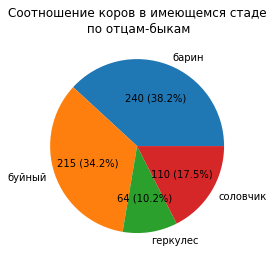

In [15]:
#построим график типа pie по таблице ferma_dad с категориальным признаком распределения по отцам-быкам в имеющемся стаде

plt.figure(figsize=[4, 4])

ferma_dad_grouped = ferma_dad['dad_name'].count()
ferma_dad.groupby('dad_name')['dad_name'].count().plot(kind='pie', 
             title ="Cоотношение коров в имеющемся стаде\n по отцам-быкам",
             radius=1,
             ylabel='',
             autopct=lambda x: f'{absolute_value(x, ferma_dad_grouped)} ({x:.1f}%)');


**Вывод**

Количественные признаки распределены не "нормально", за исключением содержания жира в молоке (protein). В признаке Удой выявлено аномальное значение по одной из коров - его заменили на среднее по стаду. Категориальные признаки (бинарные) показывают более-менее пропорциональное разделение стада (от 50/50 до 40/60), за исключением соотношения коров по возрасту - подавляющее большинство (более 82%) это коровы старше 2 лет. Также стоит отметить, что только 60% коров дают вкусное молоко (по собственной оценке фермера). По таблице об отцах-быках стада видно, что 72% коров от 2-х отцов.

В таблице cows данные для применения действующей модели, они не подлежат обучению и по ним нужно будет определить целевой признак, для выборка подходящих к покупке коров, поэтому нет смысла оценивать статистике по этой выборке.

С учетом значительной разницы в масштабах данных по разным признакам, а также наличия большого количества категориальных признаков - перед обучением модели необходимо будет провести масштабирование данных и кодирование категориальных признаков.

## Корреляционный анализ
<a id='Корреляционный-анализ'></a> [К содержанию](#К-содержанию) 

,milk_yield,efu,crude_protein,spr,fat,protein
milk_yield,1.000,0.763,0.437,0.788,0.687,-0.006
efu,0.763,1.000,0.387,0.740,0.688,-0.014
crude_protein,0.437,0.387,1.000,0.485,0.395,0.228
spr,0.788,0.740,0.485,1.000,0.700,0.110
fat,0.687,0.688,0.395,0.700,1.000,0.043
protein,-0.006,-0.014,0.228,0.110,0.043,1.000


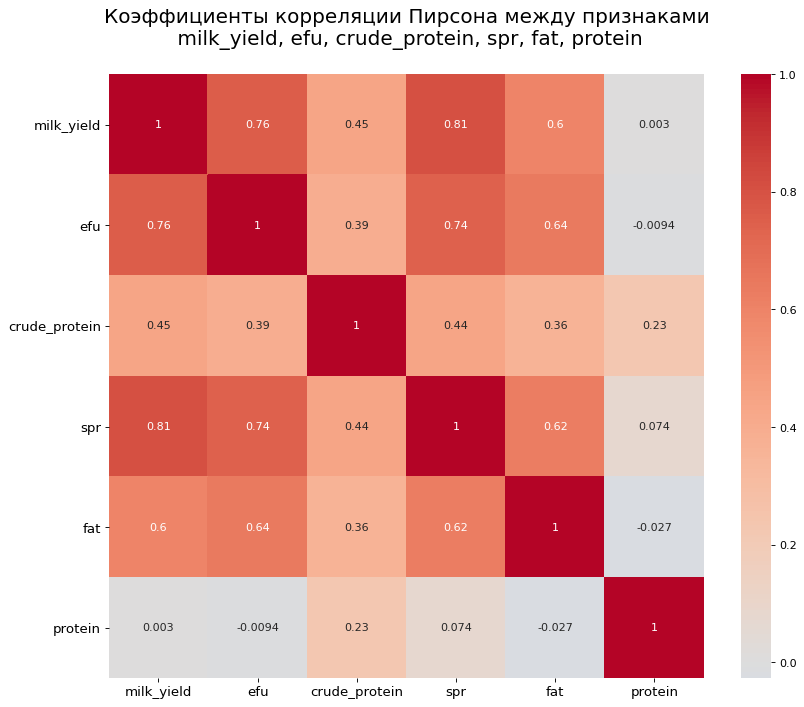

In [16]:
# проверим связи между количественными признаками
# так как у нас данные в большинстве распределены ненормально используем коэффициент Спирмена
display(ferma[['milk_yield','efu','crude_protein','spr','fat','protein']].corr(method='spearman'))

# или в виде heatmap для наглядности
plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(ferma[['milk_yield','efu','crude_protein','spr','fat','protein']].corr(), 
            xticklabels=ferma[['milk_yield','efu','crude_protein','spr','fat','protein']].corr().columns, 
            yticklabels=ferma[['milk_yield','efu','crude_protein','spr','fat','protein']].corr().columns, 
            cmap='coolwarm' , 
            center=0, 
            annot=True)

plt.title('Коэффициенты корреляции Пирсона между признаками\n milk_yield, efu, crude_protein, spr, fat, protein\n', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation='horizontal')
plt.show()

По таблице корреляции видим, что почти все количественные признаки имеют связь как с целевым признаком Удой(milk_yield), так и между собой за исключением признака молока Белок(protein) - единственная связь (слабая, коэффициент Спирмена 0.23) которого выявлена с количеством Сырого протеина(crude_protein) в корме коров.

Посмотрим на связи целевого признака Удой(milk_yield) c теми же количественными признаками с учетом категориальных признаков breed, pasture, dad_breed, taste, age:


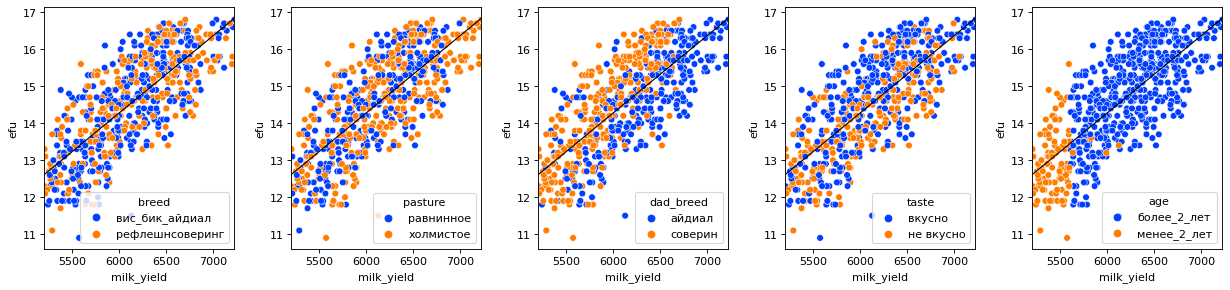

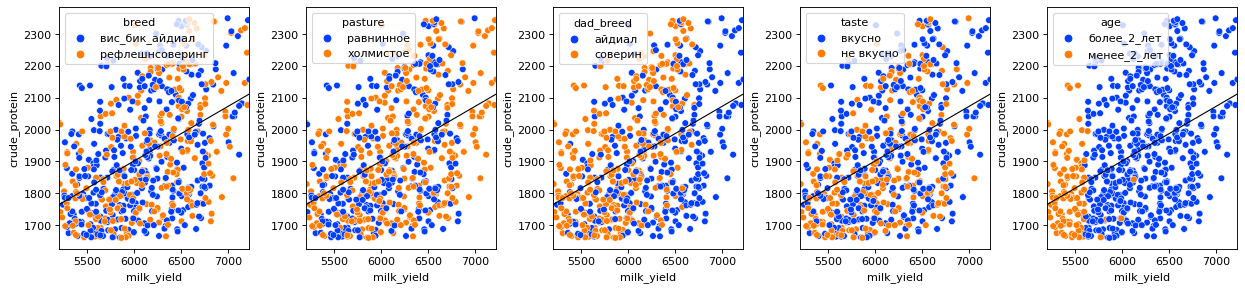

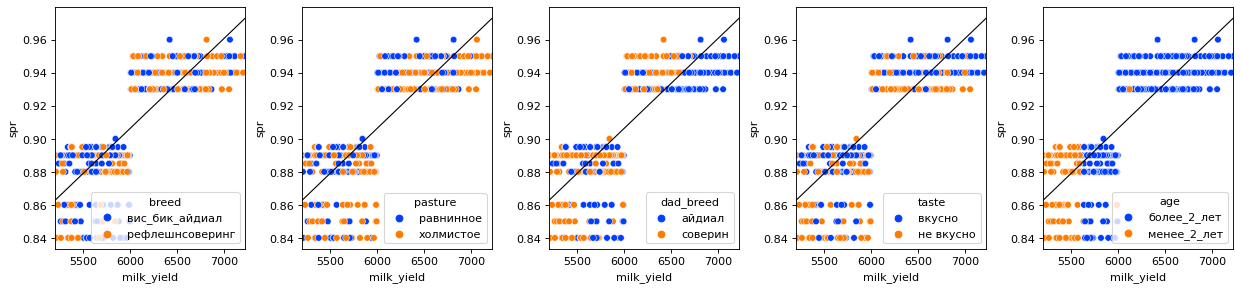

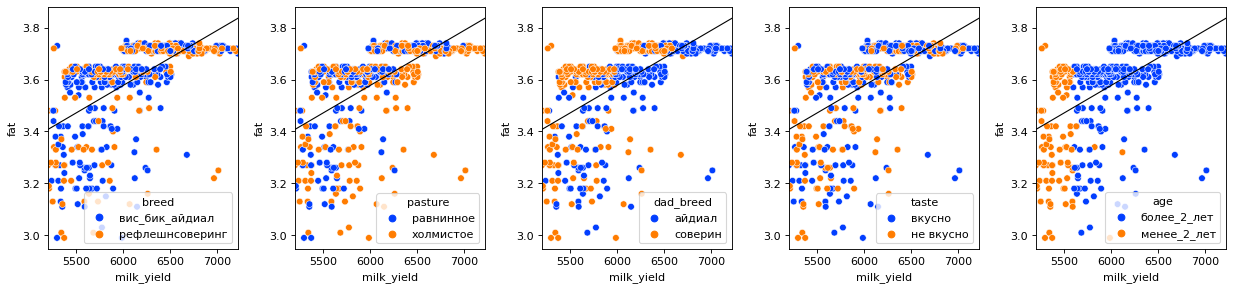

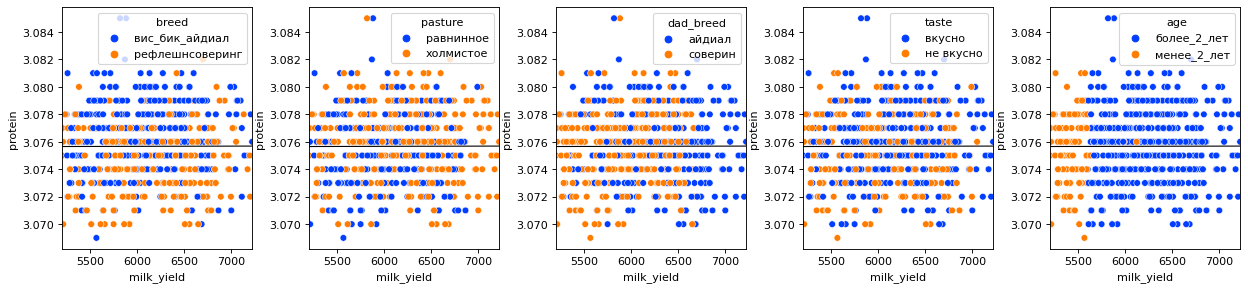

In [17]:
numeric_features = ['efu','crude_protein','spr','fat','protein']
сategorical_features = ['breed','pasture','dad_breed','taste','age']

for n_feature in numeric_features:
    plt.figure(figsize=(19,4), dpi= 80)    
    plt.subplots_adjust(wspace=0.3, hspace=0.1)
    for c_feature in сategorical_features:
        i = сategorical_features.index(c_feature) #вычисляем номер диаграммы для отражения на графике
        plt.subplot(1,5,i+1)
        sns.scatterplot(x='milk_yield', y=n_feature, data=ferma, palette='bright', hue=c_feature)
        sns.regplot(x='milk_yield', y=n_feature, data=ferma, scatter=False, color='black',line_kws={'linewidth': 1}, ci=None)
    plt.show();


Коэффициент корреляции Спирмена по зависимости Удоя от ЭКЕ = 0.76
Коэффициент детерминации R2 по зависимости Удоя от ЭКЕ = 0.97
Коэффициент корреляции Спирмена по зависимости Удоя от ЭКЕ в квадрате = 0.76
Коэффициент детерминации R2 по зависимости Удоя от ЭКЕ в квадрате = 1.00


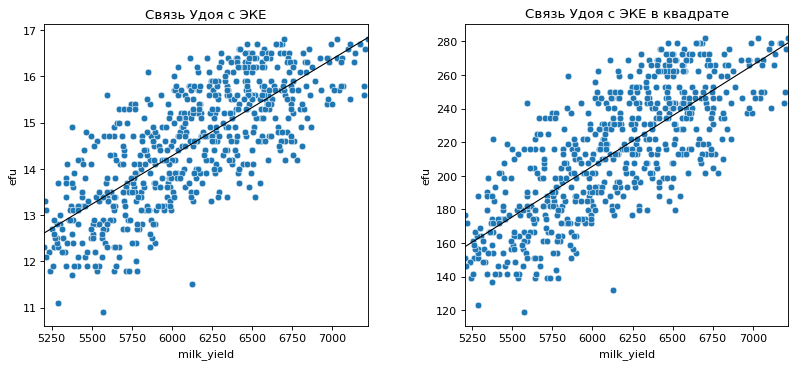

In [18]:
# проверим дополнительно связь квадрата ЭКЕ(efu) с Удоем(milk_yield) в сравнении просто ЭКЕ с Удоем 

plt.figure(figsize=(12,5), dpi= 80)    
plt.subplots_adjust(wspace=0.3, hspace=0.1)

plt.subplot(1,2,1)
plt.title('Связь Удоя с ЭКЕ')
sns.scatterplot(x='milk_yield', y='efu', data=ferma, palette='bright')
sns.regplot(x='milk_yield', y='efu', data=ferma, scatter=False, color='black',line_kws={'linewidth': 1}, ci=None)

plt.subplot(1,2,2)
plt.title('Связь Удоя с ЭКЕ в квадрате')
efu_2 = ferma['efu']**2
sns.scatterplot(x='milk_yield', y=efu_2, data=ferma, palette='dark')
sns.regplot(x='milk_yield', y=efu_2, data=ferma, scatter=False, color='black',line_kws={'linewidth': 1}, ci=None);


# Min-Max нормализация
milk_yield_norm = (ferma['milk_yield'] - np.min(ferma['milk_yield'])) / (np.max(ferma['milk_yield']) - np.min(ferma['milk_yield']))
efu_norm = milk_yield_norm = (ferma['efu'] - np.min(ferma['efu'])) / (np.max(ferma['efu']) - np.min(ferma['efu']))
efu_2_norm = milk_yield_norm = (efu_2 - np.min(efu_2)) / (np.max(efu_2) - np.min(efu_2))

corr_my_efu = ferma['milk_yield'].corr(ferma['efu'], method='spearman')
r2_1 = r2_score(milk_yield_norm, efu_norm)
print(f'Коэффициент корреляции Спирмена по зависимости Удоя от ЭКЕ = {corr_my_efu:.2f}')
print(f'Коэффициент детерминации R2 по зависимости Удоя от ЭКЕ = {r2_1:.2f}')

corr_my_efu2 = ferma['milk_yield'].corr(efu_2, method='spearman')
r2_2 = r2_score(milk_yield_norm, efu_2_norm)
print(f'Коэффициент корреляции Спирмена по зависимости Удоя от ЭКЕ в квадрате = {corr_my_efu2:.2f}')
print(f'Коэффициент детерминации R2 по зависимости Удоя от ЭКЕ в квадрате = {r2_2:.2f}')


In [19]:
#проверка на мультиколлинеарность с помощью VIF(Variance Inflation Factor)

ferma_VIF = ferma.loc[:,['efu','crude_protein','spr','fat','protein']]

# Добавление столбца с константой для расчёта VIF
ferma_VIF.loc[:, 'Intercept'] = 1

# Расчёт VIF для каждого признака
vif_data = pd.DataFrame()
vif_data['feature'] = ferma_VIF.columns
vif_data['VIF'] = [variance_inflation_factor(ferma_VIF.values, i) for i in range(ferma_VIF.shape[1])]

print(vif_data)


         feature         VIF
0            efu       2.553
1  crude_protein       1.344
2            spr       2.579
3            fat       1.879
4        protein       1.079
5      Intercept 1568391.338


**Вывод**

По таблице корреляции видим явную линейную зависимость между целевым признаком Удоя(milk_yield) и количественным признаком crude_protein (коэффициент корреляции Спирмена 0.45). Также  можем наблюдать связь между целевым признаком Удоя (milk_yield)  и признаками spr  и fat (коэффициент корреляции 0.81 и 0.6 соответственно), но уже нелинейным образом(возможно, это связано с ненормальным праспределением этих признаков). Связи протеина в молоке с количеством удоя нет совсем, и влияние категориальных факторов Породы, Вкуса не наблюдается, при этом есть разница между типа пастбищ - с холмистых выходит больше Удой, как и по признаку породы отца - коровы от Айдиал более продуктивны.
По графикам наблюдается значительное превышение дойности для коров старше двух лет, но это скорее связно с большинм количеством старших особоей в стаде, а также особенностью, что коровы редко телятся в раннем возрасте(до 2-х лет), соответственно производят молока значительно меньше.

**Дополнительно**:
- провели исследование на предмент линейной зависимости признака ЭКЕ(efu) и целевого признака Удой(milk_yield), а также признака ЭКЕ в квадрате и целевого признака Удой(milk_yield) - большая линейность связи выявлена именно во втормо случае - с квадратами значений признака ЭКЕ, в дальнейшем необходимо будет проверить и этот производный признак при обучении модели линейной регрессии на прогнозирование Удоя.

- мультиколлениарность не наблюдается, максимальная корреляция между входными признаками spr и efu - 0.74, при этом исключать признаки обычно рекомендуется при значении коэффициента корреляции от 0,9 до 0,95. Провели также проверку на мультиколлинеарность с помощью метода VIF(Variance Inflation Factor) - он также не показал наличие мультиколлинеарности между количесвенными признаками.


## Обучение модели линейной регрессии
<a id='Обучение-модели-линейной-регрессии'></a> [К содержанию](#К-содержанию) 

Для обучения и оценки моделей линейной регрессии подготовим несколько стандартных функций:

In [20]:
# функция подготовки данных и обучения модели

def train_lr_model(X,y,cat_col_names,num_col_names):

    RANDOM_STATE = 42

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        random_state=RANDOM_STATE)
    
    # подготовка признаков (масштабирование и кодирование)
    try:
        encoder = OneHotEncoder(drop='first', sparse_output=False)
    except:
        encoder = OneHotEncoder(drop='first', sparse=False)
        
    X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
    X_test_ohe = encoder.transform(X_test[cat_col_names])
    
    try:
        encoder_col_names = encoder.get_feature_names_out()
    except:
        encoder_col_names = encoder.get_feature_names()

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[num_col_names])
    X_test_scaled = scaler.transform(X_test[num_col_names])
    
    X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
    X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)
    
    X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
    X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

        
    # обучение модели и получение предсказаний на тестовых данных
    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_test)
    
    return scaler, encoder, predictions, y_test, model_lr, X_train


In [21]:
# функция оценки остатков

def residuals_check(predictions,y_test):

    #считаем остатки
    residuals = y_test - predictions
    
    # строим гистограмму частотности распределения и диаграмму рассеяния
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
    #axes[0].hist(x=residuals, bins=30)
    heights, bins, _ = axes[0].hist(x=residuals, bins=30)
    axes[0].vlines(x=residuals.mean(), colors='red', ymin=axes[0].get_ylim()[0], ymax=max(heights), label='Среднее')
    axes[0].vlines(x=residuals.median(), colors='red', ymin=axes[0].get_ylim()[0], ymax=max(heights), linestyles='--', label='Медиана')    
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].legend()
    
    axes[1].scatter(x=predictions,y=residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    
    sns.residplot(x=predictions, y=residuals, lowess=True, ax=axes[2])  # Use the residplot function from Seaborn
    axes[2].set_title('Анализ дисперсии')
    axes[2].set_xlabel('Предсказания модели')
    axes[2].set_ylabel('Остатки')
    
    plt.show()

Обучение модели прогнозирования целевого признака Удой(milk_yield) - **#1**.

При обучении модели не имеет принципиального значения использовать характеристики молока - Белок, Жирность, Вкус, т.к. эти признаки производного продукта вряд ли объективно влияют на Удой, и корреляция с Удоем только у признака жирности, при этом причинно-следственная связь может быть вообще обратная.
Признак Породы коровы не выявил связи с Удоем, однако, по идее специфика породы может влиять на средний рамер Удоя, и учитывая незначительный набор данных для обучения данный признак можем включить в обучающую выборку.

Обязательно для обучения модели нужно включить количественные характеристики: ЭКЕ(efu), Сырой протеин(crude_protein), СПО(spr), а также категориальные признаки Тип пастбища(pasture), Порода быка-отца(dad_breed), Возраст(age) - т.к. влияние этих признаков наиболее очевидно.

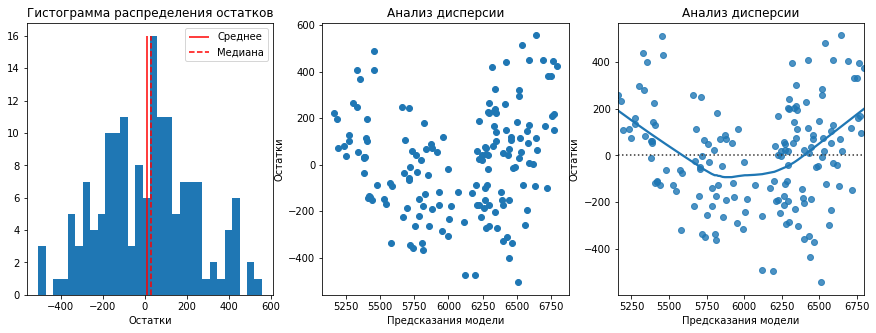

In [22]:
#обучение модели и предсказание на тестовой выборке

X = ferma.drop(['id','milk_yield','fat','protein','taste'], axis=1)
y = ferma['milk_yield']

cat_col_names = ['breed', 'pasture', 'dad_breed','age']
num_col_names = ['efu','crude_protein','spr']

scaler_first, encoder_first, predictions_first, y_test_first, model_first, X_train_first = train_lr_model(X,y, cat_col_names, num_col_names)

residuals_check(predictions_first,y_test_first)


In [23]:
# посчитаем и выведем метрики 
mae = mean_absolute_error(y_test_first, predictions_first)
mse = mean_squared_error(y_test_first, predictions_first)
try:
    rmse = root_mean_squared_error(y_test_first, predictions_first) 
except:
    rmse = mean_squared_error(y_test_first, predictions_first, squared=False)
    
r2 = r2_score(y_test_first, predictions_first)

print(f'Коэффициент детерминации R2 = {r2:.2f}')
print(f'Метрика MAE = {mae:.0f}')
print(f'Метрика MSE = {mse:.0f}')
print(f'Метрика RMSE = {rmse:.0f}')

# сравним первые строки прогноза с реальным значением
print('Прогнозируемое значение (первые 3 строки) = ', predictions_first.astype('int32')[:3]) 
print('Реальное значение (первые 3 строка) = ', np.array(y_test_first.reset_index(drop = True))[:3])


Коэффициент детерминации R2 = 0.82
Метрика MAE = 181
Метрика MSE = 49613
Метрика RMSE = 223
Прогнозируемое значение (первые 3 строки) =  [5236 6349 5477]
Реальное значение (первые 3 строка) =  [5315 6572 5392]


Вывод по модели **#1**:

Модель имеет предсказательную способность на уровне 82%, остатки нормально распределены и почти не имеют смещения, что положительно характеризует модель - ошибки предсказаний модели не имеют систематических отклонений и случайны, а также, что модель хорошо улавливает закономерности в данных и предсказывает значения достаточно точно.

При этом предсказательная способность не самая возможная, для повышения качества, возможно, имеет смысл:  
- учесть признак СПО(spr) как категориальный признак;
- попробовать привести признаки с нелинейным типом зависимости с целевым признаком (spr) к линейному;
- попробовать включить в модель дополнительные признаки - жирность молока, имя отца-быка.


Обучение модели прогнозирования целевого признака Удой(milk_yield) - **#2**.

Вторую модель будем обучать с учетом дополнительной предварительной подготовки данных, а именно постараемся исключить нелинейность зависимости между целевым признаком Удой (milk_yield) и входными признаками СПО(spr) и ЭКЕ(efu):

- на диаграмме рассеяния связи СПО(spr) и Удой(milk_yield) наблюдения сгруппированы в два кластера, причём есть такое значение СПО(spr), которое можно считать границей между кластерами. Чтобы устранить нелинейность, преобразуем СПО(spr) в категориальный бинарный признак, использовав эту границу;
- ЭКЕ(efu) и Удой(milk_yield) также связаны нелинейно. Нелинейность между ними можно исключить, если ввести новый признак ЭКЕ(efu) в квадрате.


array([0.89 , 0.885, 0.93 , 0.94 , 0.895, 0.95 , 0.96 , 0.85 , 0.84 ,
       0.86 , 0.88 , 0.9  ], dtype=float32)

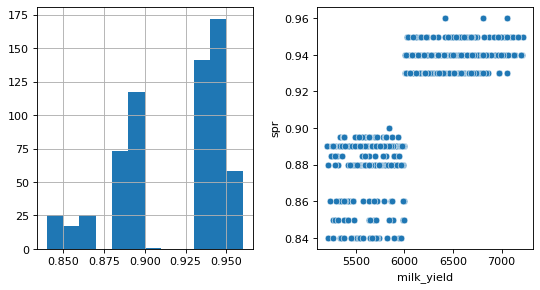

In [24]:
# посмотрим на уникальные значения spr и их распределение 
display(ferma['spr'].unique());

plt.figure(figsize=(8,4), dpi= 80)    
plt.subplots_adjust(wspace=0.3, hspace=0.1)

plt.subplot(1,2,1)
ferma['spr'].hist(bins=12)

plt.subplot(1,2,2)
sns.scatterplot(x='milk_yield', y='spr', data=ferma);

,id,milk_yield,efu,crude_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age,spr_binary
0,1,5863,14.200,1743,0.890,вис_бик_айдиал,равнинное,айдиал,3.580,3.076,вкусно,более_2_лет,0
1,2,5529,12.800,2138,0.890,вис_бик_айдиал,равнинное,соверин,3.540,3.079,вкусно,менее_2_лет,0
2,3,5810,14.000,1854,0.885,рефлешнсоверинг,холмистое,соверин,3.590,3.074,не вкусно,более_2_лет,0
3,4,5895,12.400,2012,0.885,рефлешнсоверинг,холмистое,айдиал,3.400,3.075,не вкусно,более_2_лет,0
4,5,5302,12.800,1675,0.885,вис_бик_айдиал,равнинное,соверин,3.730,3.073,вкусно,менее_2_лет,0


,id,milk_yield,efu,crude_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age,spr_binary
624,625,6812,15.400,1964,0.940,рефлешнсоверинг,равнинное,айдиал,3.740,3.075,не вкусно,более_2_лет,1
625,626,5513,12.900,1700,0.880,рефлешнсоверинг,равнинное,соверин,3.640,3.073,вкусно,менее_2_лет,0
626,627,5970,14.400,1837,0.880,рефлешнсоверинг,холмистое,соверин,3.640,3.075,не вкусно,более_2_лет,0
627,628,5746,13.800,1994,0.890,рефлешнсоверинг,равнинное,соверин,3.640,3.077,вкусно,более_2_лет,0
628,629,6503,16.200,2283,0.940,вис_бик_айдиал,холмистое,соверин,3.710,3.076,вкусно,более_2_лет,1


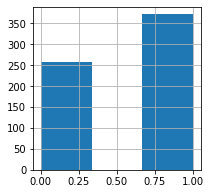

In [25]:
# качественное разделение по целевому признаку Удой проходит по границе значения признака spr на уровне 0.92 - его и примем за порог при формировании категориального признака
# добавим отдельный столбец spr_binary с соответствующим категориальным признаком

ferma['spr_binary'] = ferma['spr'].apply(lambda x: 1 if x > 0.92 else 0)

# проверим результат
display(ferma.head(5))
display(ferma.tail(5))

ferma['spr_binary'].hist(figsize=(3,3),bins=3);

,id,milk_yield,efu,crude_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age,spr_binary,efu_square
0,1,5863,14.200,1743,0.890,вис_бик_айдиал,равнинное,айдиал,3.580,3.076,вкусно,более_2_лет,0,201.640
1,2,5529,12.800,2138,0.890,вис_бик_айдиал,равнинное,соверин,3.540,3.079,вкусно,менее_2_лет,0,163.840
2,3,5810,14.000,1854,0.885,рефлешнсоверинг,холмистое,соверин,3.590,3.074,не вкусно,более_2_лет,0,196.000
3,4,5895,12.400,2012,0.885,рефлешнсоверинг,холмистое,айдиал,3.400,3.075,не вкусно,более_2_лет,0,153.760
4,5,5302,12.800,1675,0.885,вис_бик_айдиал,равнинное,соверин,3.730,3.073,вкусно,менее_2_лет,0,163.840


,id,milk_yield,efu,crude_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age,spr_binary,efu_square
624,625,6812,15.400,1964,0.940,рефлешнсоверинг,равнинное,айдиал,3.740,3.075,не вкусно,более_2_лет,1,237.160
625,626,5513,12.900,1700,0.880,рефлешнсоверинг,равнинное,соверин,3.640,3.073,вкусно,менее_2_лет,0,166.410
626,627,5970,14.400,1837,0.880,рефлешнсоверинг,холмистое,соверин,3.640,3.075,не вкусно,более_2_лет,0,207.360
627,628,5746,13.800,1994,0.890,рефлешнсоверинг,равнинное,соверин,3.640,3.077,вкусно,более_2_лет,0,190.440
628,629,6503,16.200,2283,0.940,вис_бик_айдиал,холмистое,соверин,3.710,3.076,вкусно,более_2_лет,1,262.440


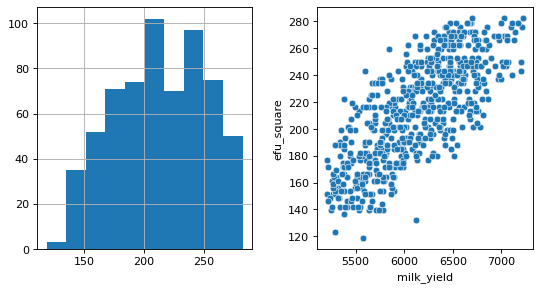

In [26]:
# добавим еще один столбец efu_squre, который заполним квадратами соответствующих значений исходного признака
ferma['efu_square'] = ferma['efu'] ** 2

# проверим результат
display(ferma.head(5))
display(ferma.tail(5))


plt.figure(figsize=(8,4), dpi= 80)    
plt.subplots_adjust(wspace=0.3, hspace=0.1)

plt.subplot(1,2,1)
ferma['efu_square'].hist(bins=10);

plt.subplot(1,2,2)
sns.scatterplot(x='milk_yield', y='efu_square', data=ferma);


С учетом произведенных преобразований обучим вторую модель по аналогии с первой:

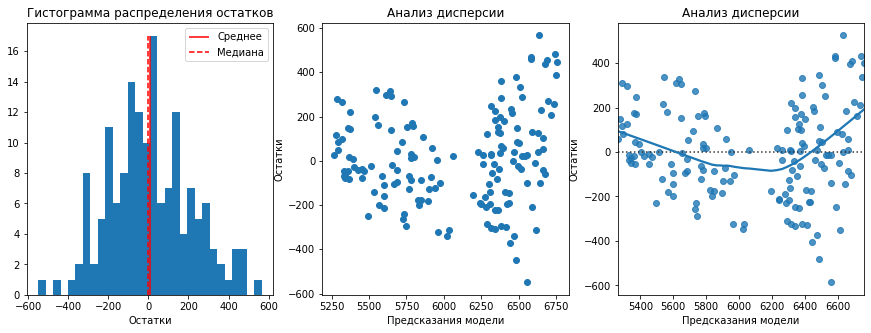

In [27]:
#обучение модели и предсказание на тестовой выборке

X = ferma.drop(['id','milk_yield','efu','spr','fat','protein','taste'], axis=1)
y = ferma['milk_yield']

cat_col_names = ['breed', 'pasture', 'dad_breed','age','spr_binary']
num_col_names = ['crude_protein','efu_square']

scaler_second, encoder_second, predictions_second, y_test_second, model_second, X_train_second = train_lr_model(X,y, cat_col_names, num_col_names)

residuals_check(predictions_second,y_test_second)

In [28]:
# посчитаем и выведем метрики 
mae = mean_absolute_error(y_test_second, predictions_second)
mse = mean_squared_error(y_test_second, predictions_second)

try:
    rmse = root_mean_squared_error(y_test_second, predictions_second) 
except:
    rmse = mean_squared_error(y_test_second, predictions_second, squared=False) 

r2 = r2_score(y_test_second, predictions_second)

print(f'Коэффициент детерминации R2 = {r2:.2f}')
print(f'Метрика MAE = {mae:.0f}')
print(f'Метрика MSE = {mse:.0f}')
print(f'Метрика RMSE = {rmse:.0f}')

# сравним первые строки прогноза с реальным значением
print('Прогнозируемое значение (первые 3 строки) = ', predictions_second.astype('int32')[:3]) 
print('Реальное значение (первые 3 строка) = ', np.array(y_test_second.reset_index(drop = True))[:3])

Коэффициент детерминации R2 = 0.84
Метрика MAE = 164
Метрика MSE = 42833
Метрика RMSE = 207
Прогнозируемое значение (первые 3 строки) =  [5360 6374 5533]
Реальное значение (первые 3 строка) =  [5315 6572 5392]


Вывод по модели **#2**:

Предсказательная способность модели улушилась до 84%, распределение остатков, по-прежнему, очевидно нормальное, при этом разброс остатков при прогнозировании больших значений удоя стал наглядно больше, то есть модель хуже прогнозирует сегмент коров с большим параметром Удоя.

Метрики MSE, RMSE, MAE заметно уменьшились, что подтверждает положительный эффект от дополнительной подготовки входных признаков СПО(spr) и ЭКЕ(efu).
Для доработки модель можно еще включить дополнительные признаки - жирность молока, имя отца-быка.

Обучение модели прогнозирования целевого признака Удой(milk_yield) - **#3**.

Для обучения третьей модели добавим категориальный признак из второй таблицы с именем отца-быка каждой коровы.

In [29]:
display(ferma.shape)
ferma_dad.shape

(629, 14)

(629, 2)

In [30]:
# проверим, что данные столбца 'id' обоих таблиц совпадают
rez = (ferma.loc[:,'id'] == ferma_dad.loc[:,'id']).sum()
rez

629

In [31]:
# добавляем столбец
ferma = ferma.merge(ferma_dad, on='id', how='left')
display(ferma.head())

# проверяем на пропуски
display(ferma.isna().sum())

,id,milk_yield,efu,crude_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age,spr_binary,efu_square,dad_name
0,1,5863,14.200,1743,0.890,вис_бик_айдиал,равнинное,айдиал,3.580,3.076,вкусно,более_2_лет,0,201.640,буйный
1,2,5529,12.800,2138,0.890,вис_бик_айдиал,равнинное,соверин,3.540,3.079,вкусно,менее_2_лет,0,163.840,соловчик
2,3,5810,14.000,1854,0.885,рефлешнсоверинг,холмистое,соверин,3.590,3.074,не вкусно,более_2_лет,0,196.000,барин
3,4,5895,12.400,2012,0.885,рефлешнсоверинг,холмистое,айдиал,3.400,3.075,не вкусно,более_2_лет,0,153.760,буйный
4,5,5302,12.800,1675,0.885,вис_бик_айдиал,равнинное,соверин,3.730,3.073,вкусно,менее_2_лет,0,163.840,барин


id               0
milk_yield       0
efu              0
crude_protein    0
spr              0
breed            0
pasture          0
dad_breed        0
fat              0
protein          0
taste            0
age              0
spr_binary       0
efu_square       0
dad_name         0
dtype: int64

С учетом произведенных преобразований обучим вторую модель по аналогии с первыми двумя:

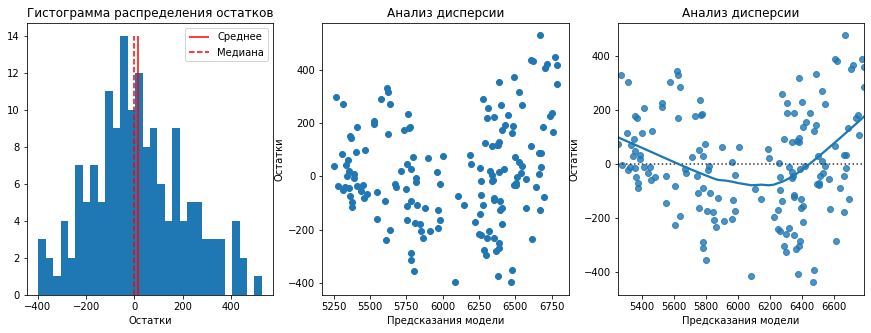

In [32]:
#обучение модели и предсказание на тестовой выборке

X = ferma.drop(['id','milk_yield','efu','fat','spr','protein','taste'], axis=1)
y = ferma['milk_yield']

cat_col_names = ['breed', 'pasture', 'dad_breed','age','spr_binary','dad_name']
num_col_names = ['crude_protein','efu_square']

scaler_third, encoder_third, predictions_third, y_test_third, model_third, X_train_third = train_lr_model(X,y, cat_col_names, num_col_names)

residuals_check(predictions_third,y_test_third)

In [33]:
# посчитаем и выведем метрики 
mae = mean_absolute_error(y_test_third, predictions_third)
mse = mean_squared_error(y_test_third, predictions_third)

try:
    rmse = root_mean_squared_error(y_test_third, predictions_third) 
except:
    rmse = mean_squared_error(y_test_third, predictions_third, squared=False)
    
r2 = r2_score(y_test_third, predictions_third)

print(f'Коэффициент детерминации R2 = {r2:.2f}')
print(f'Метрика MAE = {mae:.0f}')
print(f'Метрика MSE = {mse:.0f}')
print(f'Метрика RMSE = {rmse:.0f}')

# сравним первые строки прогноза с реальным значением
print('Прогнозируемое значение (первые 3 строки) = ', predictions_third.astype('int32')[:3]) 
print('Реальное значение (первые 3 строка) = ', np.array(y_test_third.reset_index(drop = True))[:3])

Коэффициент детерминации R2 = 0.86
Метрика MAE = 153
Метрика MSE = 37651
Метрика RMSE = 194
Прогнозируемое значение (первые 3 строки) =  [5358 6351 5550]
Реальное значение (первые 3 строка) =  [5315 6572 5392]


Вывод по модели **#3**:

Предсказательная способность модели улушилась еще до 86%, распределение остатков, по-прежнему, нормальное, при этом разброс остатков при прогнозировании больших значений Удоя уменьшился, то есть точность модели при прогнозировании сегмента коров с большим параметром Удоя повысилась.

Метрики MSE, RMSE, MAE также уменьшились, что подтверждает положительный эффект от добавления в модель данных по именам отцов-быков. 

**Третья модель** показывает лучшие результаты прогнозирования целевого признака, соответственно для дальнейшего прогнозирования объема Удоя по предлагаемым к покупке коровам будем применять именно третью модель.
Также рассчитаем доверительный интервал для результатов пронозирования третьей модели:

In [34]:
print(f'95% доверительный интервал Удоя коров по тренировочной выборке для третьей модели сосставляет: \
{round(np.quantile(np.array(predictions_third), 0.025), 0)}, \
{round(np.quantile(np.array(predictions_third), 0.975), 0)}')

95% доверительный интервал Удоя коров по тренировочной выборке для третьей модели сосставляет: 5312.0, 6753.0


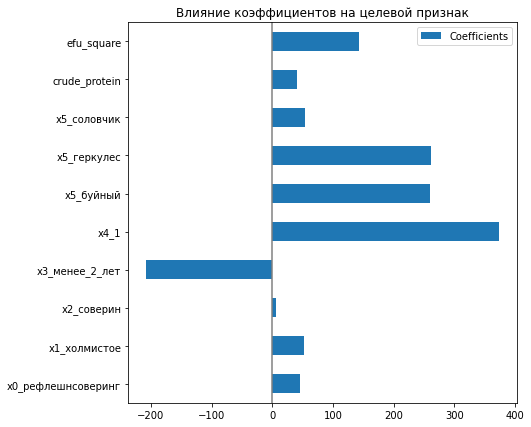

In [35]:
#посмотрим веса(влияние) коэффициентов в третьей модели
coefs = pd.DataFrame(model_third.coef_, columns=["Coefficients"], index=X_train_third.columns)

coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Влияние коэффициентов на целевой признак")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Спрогнозируем объем удоя коров, которые фермер рассматривает к покупке, используя третью модель, и, предварительно подготовив данные по целевому набору коров для применения модели.

In [36]:
cows.head()

,breed,pasture,dad_breed,dad_name,fat,protein,age
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.580,3.076,более_2_лет
1,вис_бик_айдиал,равнинное,соверин,буйный,3.540,3.079,менее_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,3.590,3.074,более_2_лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.400,3.075,более_2_лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.730,3.073,более_2_лет


In [37]:
display(ferma.head())
display(cows.head())

,id,milk_yield,efu,crude_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age,spr_binary,efu_square,dad_name
0,1,5863,14.200,1743,0.890,вис_бик_айдиал,равнинное,айдиал,3.580,3.076,вкусно,более_2_лет,0,201.640,буйный
1,2,5529,12.800,2138,0.890,вис_бик_айдиал,равнинное,соверин,3.540,3.079,вкусно,менее_2_лет,0,163.840,соловчик
2,3,5810,14.000,1854,0.885,рефлешнсоверинг,холмистое,соверин,3.590,3.074,не вкусно,более_2_лет,0,196.000,барин
3,4,5895,12.400,2012,0.885,рефлешнсоверинг,холмистое,айдиал,3.400,3.075,не вкусно,более_2_лет,0,153.760,буйный
4,5,5302,12.800,1675,0.885,вис_бик_айдиал,равнинное,соверин,3.730,3.073,вкусно,менее_2_лет,0,163.840,барин


,breed,pasture,dad_breed,dad_name,fat,protein,age
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.580,3.076,более_2_лет
1,вис_бик_айдиал,равнинное,соверин,буйный,3.540,3.079,менее_2_лет
2,рефлешнсоверинг,равнинное,соверин,барин,3.590,3.074,более_2_лет
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.400,3.075,более_2_лет
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.730,3.073,более_2_лет


In [38]:
# добавим столбцы с данными корма(признаки efu, crude_protein,spr), которым фермер будет кормить вновьприобретенных коров
cows = cows.assign(efu=np.nan, crude_protein=np.nan, spr=np.nan)

# считаем средние значения и увеличиваем их на 5%
mean_values = ferma.loc[:, ['efu', 'crude_protein', 'spr']].mean() * 1.05

# присваиваем новые значения каждому столбцу
cows['efu'] = mean_values['efu']
cows['crude_protein'] = mean_values['crude_protein']
cows['spr'] = mean_values['spr']


In [39]:
#подготовим данные в добавленных столбцах efu и spr как для третьей модели
cows['efu_square'] = cows['efu'] ** 2
cows['spr_binary'] = cows['spr'].apply(lambda x: 1 if x > 0.92 else 0)

cat_col_names = ['breed', 'pasture', 'dad_breed','age','spr_binary','dad_name']
num_col_names = ['crude_protein','efu_square']

X_predict = cows.drop(['fat','spr','protein','efu'], axis=1)

# подготовим признаки в целевой таблице под третью модель (масштабирование и кодирование)        
X_predict_ohe = encoder_third.transform(X_predict[cat_col_names])
    
try:
    encoder_col_names = encoder_third.get_feature_names_out()
except:
    encoder_col_names = encoder_third.get_feature_names()

X_predict_scaled = scaler_third.transform(X_predict[num_col_names])    
X_predict_ohe = pd.DataFrame(X_predict_ohe, columns=encoder_col_names)    
X_predict_scaled = pd.DataFrame(X_predict_scaled, columns=num_col_names)    
X_predict = pd.concat([X_predict_ohe, X_predict_scaled], axis=1)
    
#проверим получившуюся таблицу признаков
X_predict.head()


,x0_рефлешнсоверинг,x1_холмистое,x2_соверин,x3_менее_2_лет,x4_1,x5_буйный,x5_геркулес,x5_соловчик,crude_protein,efu_square
0,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,0.540,0.526
1,0.000,0.000,1.000,1.000,1.000,1.000,0.000,0.000,0.540,0.526
2,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.540,0.526
3,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.540,0.526
4,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.540,0.526


In [40]:
#применим третью модель к подготовленной выборке для получения прогноза Удоя(milk_yield)
cows['milk_yield'] = model_third.predict(X_predict).round()

cows

,breed,pasture,dad_breed,dad_name,fat,protein,age,efu,crude_protein,spr,efu_square,spr_binary,milk_yield
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.580,3.076,более_2_лет,15.271,2019.532,0.959,233.206,1,6550.000
1,вис_бик_айдиал,равнинное,соверин,буйный,3.540,3.079,менее_2_лет,15.271,2019.532,0.959,233.206,1,6294.000
2,рефлешнсоверинг,равнинное,соверин,барин,3.590,3.074,более_2_лет,15.271,2019.532,0.959,233.206,1,6288.000
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.400,3.075,более_2_лет,15.271,2019.532,0.959,233.206,1,6595.000
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.730,3.073,более_2_лет,15.271,2019.532,0.959,233.206,1,6542.000
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.130,3.078,менее_2_лет,15.271,2019.532,0.959,233.206,1,6341.000
6,вис_бик_айдиал,холмистое,айдиал,геркулес,3.480,3.077,более_2_лет,15.271,2019.532,0.959,233.206,1,6550.000
7,вис_бик_айдиал,равнинное,соверин,буйный,3.550,3.076,более_2_лет,15.271,2019.532,0.959,233.206,1,6502.000
8,рефлешнсоверинг,равнинное,соверин,барин,3.710,3.077,более_2_лет,15.271,2019.532,0.959,233.206,1,6288.000
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.130,3.075,менее_2_лет,15.271,2019.532,0.959,233.206,1,6387.000


**Вывод**

При подготовке модели прогнозирования Удоя были проведены следующие действия:

- по ранее предподготовленным данным были отобраны входные признаки для обучения модели - характеристики корма (ЭКЕ, СПО, Сырой протеин), характеристики пастбища и конкретной особи(порода, порода отца-быка, имя отца-быка, возраст);
- проведена подготовка данных с масштабирование количественных признаков и кодированием категориальных признаков;
- построены три модели, различающиеся набором признаков (с данными по имени отца-быка и без) и/или корректировками нелинейного характера зависимостей целевого признака с данными по ЭКЕ и СПО;

По итогу анализа наилучшие результаты по прогнозирующей способности(86%) и метрикам оценки ошибок (MAE = 153кг, MSE = 37651кг2, RMSE = 194кг) показала третья модель.
Третья модель была применена к целевому датасету с параметрами коров, рассматриваемых к покупке, с учетом построенного прогноза по целевому признаку Удоя не менее 6000 кг в год - **все рассматриваемые коровы подходят для покупки**.


## Обучение модели логистической регрессии
<a id='Обучение-модели-логистической-регрессии'></a> [К содержанию](#К-содержанию) 

Поскольку планируется подготовить и обучить только одну модель логистической регрессии для оценки целевого признака Вкус(taste) отдельных функций по аналогии с моделями линейной регрессии выделять не будем. На базе уже дополненной на предыдущем этапе таблицы ferma проведем необходимую подготовку данных, разобьем данные на тренировочную и тестовую выборки, разделим целевой признак и входные признаки и далее проведем обучение модели.

Для обучения оставим все исходные признаки, и уберем производные efu_square, spr_binary, которые рассчитывались для прогнозирования целевого признака Удой(milk_yield) и для нового целевого признака Вкус(taste) не актуальны, объем самого Удоя также логически мало связан со вкусом молока, поэтому его включать также не будем.

Перед подготовкой к обучению посмотрим на распределение входных признаков в разбивке по целевому признаку Вкус(taste).

In [41]:
ferma.head()

,id,milk_yield,efu,crude_protein,spr,breed,pasture,dad_breed,fat,protein,taste,age,spr_binary,efu_square,dad_name
0,1,5863,14.200,1743,0.890,вис_бик_айдиал,равнинное,айдиал,3.580,3.076,вкусно,более_2_лет,0,201.640,буйный
1,2,5529,12.800,2138,0.890,вис_бик_айдиал,равнинное,соверин,3.540,3.079,вкусно,менее_2_лет,0,163.840,соловчик
2,3,5810,14.000,1854,0.885,рефлешнсоверинг,холмистое,соверин,3.590,3.074,не вкусно,более_2_лет,0,196.000,барин
3,4,5895,12.400,2012,0.885,рефлешнсоверинг,холмистое,айдиал,3.400,3.075,не вкусно,более_2_лет,0,153.760,буйный
4,5,5302,12.800,1675,0.885,вис_бик_айдиал,равнинное,соверин,3.730,3.073,вкусно,менее_2_лет,0,163.840,барин


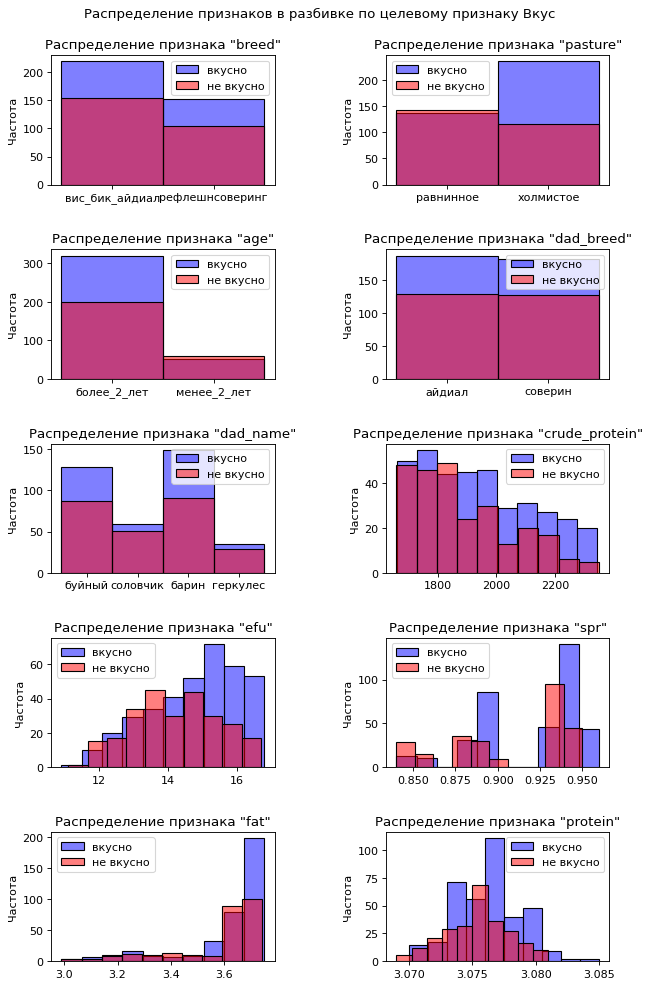

In [42]:
# разобьем данные на две группы по значению целевой переменной taste
group_1 = ferma[ferma['taste'] == 'вкусно']
group_0 = ferma[ferma['taste'] == 'не вкусно']

features = ['breed','pasture','age','dad_breed','dad_name','crude_protein','efu','spr','fat','protein']

plt.figure(figsize=[9, 15], dpi=80)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.suptitle('Распределение признаков в разбивке по целевому признаку Вкус ', y=0.92)

for index, feature in enumerate(features):  
    
    plt.subplot(5, 2, index+1)
    sns.histplot(group_1[feature], bins=10, alpha=0.5, color='b',label='вкусно')
    sns.histplot(group_0[feature], bins=10, alpha=0.5, color='r',label='не вкусно')
    plt.xlabel("")
    plt.ylabel('Частота')
    plt.legend()
    plt.title(f'Распределение признака "{feature}"')
plt.show()


In [43]:
# приведем целевой признак Вкус(taste) к цифровому виду
ferma['taste'] = ferma['taste'].apply(lambda x: 1 if x == 'вкусно' else 0)

#исключим столбцы id, efu_square, spr_binary, milk_yield и выделим целевой и входные признаки
X = ferma.drop(['id','taste','efu_square','spr_binary'], axis=1)
y = ferma['taste']

cat_col_names = ['breed','pasture','age','dad_breed','dad_name']
num_col_names = ['crude_protein','efu','spr','fat','protein','milk_yield']


In [44]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE,
    stratify=y)

# подготовка признаков (масштабирование и кодирование)
try:
    encoder_clf = OneHotEncoder(drop='first', sparse_output=False)
except:
    encoder_clf = OneHotEncoder(drop='first', sparse=False)
    
X_train_ohe = encoder_clf.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder_clf.transform(X_test[cat_col_names])

try:
    encoder_col_names = encoder_clf.get_feature_names_out()
except:
    encoder_col_names = encoder_clf.get_feature_names()

scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train[num_col_names])
X_test_scaled = scaler_clf.transform(X_test[num_col_names])

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

    
# обучение модели и получение предсказаний на тестовых данных
model_clf = LogisticRegression()
model_clf = model_clf.fit(X_train,y_train)
y_pred_clf = model_clf.predict(X_test)


Посчитаем и выведем данные для оценки модели:

milk_yield          : +0.84
efu                 : +1.90
crude_protein       : +0.73
spr                 : +1.23
breed               : +1.21
pasture             : +0.95
dad_breed           : +0.55
fat                 : +1.14
protein             : +1.67
age                 : +1.42
dad_name            : +0.90
recall:  0.871
precision:  0.638
accuracy:  0.633


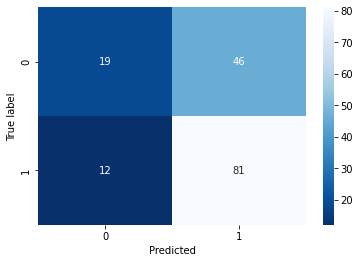

In [45]:
# посмотрим веса коэффициентов
for feature_number, feature_name in enumerate(X.columns):
    exp_weight = math.exp(model_clf.coef_[0, feature_number])
    print(f"{feature_name:<20}: {exp_weight:+.2f}")

# посчитаем и выведем матрицу ошибок
cm = confusion_matrix(y_test, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted') 

# посчитаем и выведем метрики
recall = recall_score(y_test,y_pred_clf)
precision = precision_score(y_test,y_pred_clf)
accuracy = accuracy_score(y_pred_clf, y_test) 

print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))
print('accuracy: ',round(accuracy,3));

По итогу обучения и оценки модели прогнозирования целевого признака Вкус, выяснили, что наиболее влияющими факторами на вкус молока являются - порода, объем сырого протеина, возраст, доля белка в самом молоке, имя отца-быка. 
При этом модель имеет близкое соотношение ошибок первого(метрика precision = 0.628) и второго рода (метрика recall = 0.871) c предсказательной возможностью по метрике accuracy = 0.620.

Учитывая, что для заказчика критична покупка коров, дающих именно вкусное молоко, то в таком случае целесообразнее настроить модель на большую точность при оценке Вкуса, пожертвовав при этом полнотой(какие-то подходящие коровы будут ошибочно оценены, как дающие невкусное молоко, при этом вероятность отбора коров с вкусным молоком повысится), иначе говоря целесообразно приоритезировать снижение ошибок первого рода до минимума(0), и довести метрику precision до максимума(1).

In [46]:
# посмотрим вероятности в сравнении с реальными данными
y_proba = model_clf.predict_proba(X_test)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

data.head(20)

,y_valid,y_proba
146,1,0.928
74,1,0.879
126,1,0.874
153,1,0.869
113,1,0.855
2,1,0.855
131,1,0.848
60,1,0.840
35,1,0.835
78,1,0.834


In [47]:
#распределим пороги отличные от стандарта 0.5 в промежутке от 0.60 до максимального значения 0.928
thresholds = [round(i,3) for i in np.linspace(0.70,0.928,num = 17,endpoint=False)]
print(thresholds) 

[0.7, 0.713, 0.727, 0.74, 0.754, 0.767, 0.78, 0.794, 0.807, 0.821, 0.834, 0.848, 0.861, 0.874, 0.888, 0.901, 0.915]


In [48]:
# посчитаем классификацию полученных предсказаний исходя из новых порогов
# также посчитаем значение метрики precision для полученных предсказаний при каждом пороге 
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x > i else 0)
    print(i, precision_score(data['y_valid'], data['y_pred_'+str(i)]))

0.7 0.7627118644067796
0.713 0.7547169811320755
0.727 0.7708333333333334
0.74 0.8536585365853658
0.754 0.8333333333333334
0.767 0.8620689655172413
0.78 0.9166666666666666
0.794 0.9090909090909091
0.807 0.9047619047619048
0.821 0.875
0.834 1.0
0.848 1.0
0.861 1.0
0.874 1.0
0.888 1.0
0.901 1.0
0.915 1.0


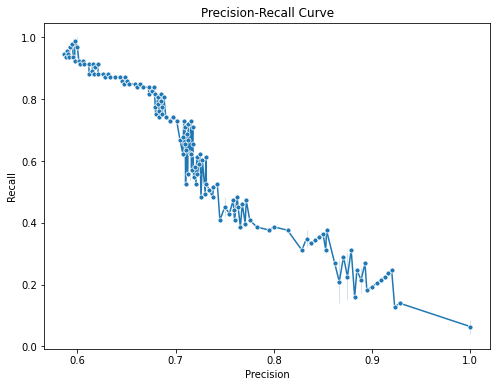

In [49]:
#для проверки построим график значений precisions для большого числа порогов
precisions, recalls, thresholds = precision_recall_curve(data['y_valid'], data['y_proba'])

plt.figure(figsize=(8, 6))
sns.lineplot(x=precisions, y=recalls, marker='.', markersize=10)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve')
plt.show()


Метрика precision максимизируется **при пороге 0.834**, посчитаем для него прочие метрики и матрицу ошибок для наглядности:

recall:  0.129
precision:  1.0
accuracy:  0.487


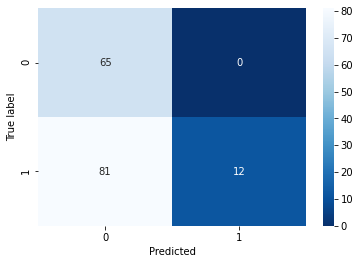

In [50]:
# посчитаем и выведем матрицу ошибок
cm = confusion_matrix(data['y_valid'], data['y_pred_0.834'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted') 

# посчитаем и выведем метрики
recall = recall_score(data['y_valid'],data['y_pred_0.834'])
precision = precision_score(data['y_valid'],data['y_pred_0.834'])
accuracy = accuracy_score(data['y_pred_0.834'], data['y_valid']) 

print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))
print('accuracy: ',round(accuracy,3));

Спрогнозируем вкус молока по целевому набору данных коров, которые фермер рассматривает к покупке, используя подготовленную модель логистической регрессии, и, предварительно подготовив данные по целевому набору коров для применения модели.

In [51]:
cows

,breed,pasture,dad_breed,dad_name,fat,protein,age,efu,crude_protein,spr,efu_square,spr_binary,milk_yield
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.580,3.076,более_2_лет,15.271,2019.532,0.959,233.206,1,6550.000
1,вис_бик_айдиал,равнинное,соверин,буйный,3.540,3.079,менее_2_лет,15.271,2019.532,0.959,233.206,1,6294.000
2,рефлешнсоверинг,равнинное,соверин,барин,3.590,3.074,более_2_лет,15.271,2019.532,0.959,233.206,1,6288.000
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.400,3.075,более_2_лет,15.271,2019.532,0.959,233.206,1,6595.000
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.730,3.073,более_2_лет,15.271,2019.532,0.959,233.206,1,6542.000
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.130,3.078,менее_2_лет,15.271,2019.532,0.959,233.206,1,6341.000
6,вис_бик_айдиал,холмистое,айдиал,геркулес,3.480,3.077,более_2_лет,15.271,2019.532,0.959,233.206,1,6550.000
7,вис_бик_айдиал,равнинное,соверин,буйный,3.550,3.076,более_2_лет,15.271,2019.532,0.959,233.206,1,6502.000
8,рефлешнсоверинг,равнинное,соверин,барин,3.710,3.077,более_2_лет,15.271,2019.532,0.959,233.206,1,6288.000
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.130,3.075,менее_2_лет,15.271,2019.532,0.959,233.206,1,6387.000


In [52]:
#исключим столбцы milk_yield, efu_square, spr_binary и выделим категориальные и количественные признаки
X_predict = cows.drop(['efu_square','spr_binary'], axis=1)

cat_col_names = ['breed','pasture','age','dad_breed','dad_name']
num_col_names = ['crude_protein','efu','spr','fat','protein','milk_yield']

# подготовка признаков (масштабирование и кодирование)
X_predict_ohe = encoder_clf.transform(X_predict[cat_col_names])

try:
    encoder_col_names = encoder_clf.get_feature_names_out()
except:
    encoder_col_names = encoder_clf.get_feature_names()

X_predict_scaled = scaler_clf.transform(X_predict[num_col_names])
X_predict_ohe = pd.DataFrame(X_predict_ohe, columns=encoder_col_names)
X_predict_scaled = pd.DataFrame(X_predict_scaled, columns=num_col_names)
X_predict = pd.concat([X_predict_ohe, X_predict_scaled], axis=1)

#проверим получившуюся таблицу признаков
X_predict.head()


,x0_рефлешнсоверинг,x1_холмистое,x2_менее_2_лет,x3_соверин,x4_буйный,x4_геркулес,x4_соловчик,crude_protein,efu,spr,fat,protein,milk_yield
0,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.570,0.596,1.469,-0.126,0.185,0.920
1,0.000,0.000,1.000,1.000,1.000,0.000,0.000,0.570,0.596,1.469,-0.364,1.359,0.388
2,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.570,0.596,1.469,-0.066,-0.599,0.375
3,1.000,1.000,0.000,0.000,1.000,0.000,0.000,0.570,0.596,1.469,-1.197,-0.207,1.013
4,1.000,0.000,0.000,0.000,1.000,0.000,0.000,0.570,0.596,1.469,0.767,-0.990,0.903


In [53]:
# применим модель к подготовленной выборке для получения прогноза Вкуса(taste)
taste = model_clf.predict(X_predict)
# и уточним соответсвующие оценки вероятностей
taste_proba = model_clf.predict_proba(X_predict)[:,1]

display(taste, taste_proba)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

array([0.77571691, 0.77291895, 0.68569101, 0.78565147, 0.58849   ,
       0.71956202, 0.79822416, 0.75194458, 0.71628865, 0.79484133,
       0.78470103, 0.61719137, 0.74688144, 0.8343702 , 0.619431  ,
       0.76317062, 0.78774159, 0.75947552, 0.68686013, 0.60621339])

In [54]:
# дополним целевую таблицу прогнозами по признаку Вкус(taste) 
# c учетом определенного ранее порога классификации 0.807
cows['taste_proba'] = taste_proba
cows['taste'] = cows['taste_proba'].apply(lambda x: 'вкусно' if x > 0.834 else 'не вкусно')

cows

,breed,pasture,dad_breed,dad_name,fat,protein,age,efu,crude_protein,spr,efu_square,spr_binary,milk_yield,taste_proba,taste
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.580,3.076,более_2_лет,15.271,2019.532,0.959,233.206,1,6550.000,0.776,не вкусно
1,вис_бик_айдиал,равнинное,соверин,буйный,3.540,3.079,менее_2_лет,15.271,2019.532,0.959,233.206,1,6294.000,0.773,не вкусно
2,рефлешнсоверинг,равнинное,соверин,барин,3.590,3.074,более_2_лет,15.271,2019.532,0.959,233.206,1,6288.000,0.686,не вкусно
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.400,3.075,более_2_лет,15.271,2019.532,0.959,233.206,1,6595.000,0.786,не вкусно
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.730,3.073,более_2_лет,15.271,2019.532,0.959,233.206,1,6542.000,0.588,не вкусно
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.130,3.078,менее_2_лет,15.271,2019.532,0.959,233.206,1,6341.000,0.720,не вкусно
6,вис_бик_айдиал,холмистое,айдиал,геркулес,3.480,3.077,более_2_лет,15.271,2019.532,0.959,233.206,1,6550.000,0.798,не вкусно
7,вис_бик_айдиал,равнинное,соверин,буйный,3.550,3.076,более_2_лет,15.271,2019.532,0.959,233.206,1,6502.000,0.752,не вкусно
8,рефлешнсоверинг,равнинное,соверин,барин,3.710,3.077,более_2_лет,15.271,2019.532,0.959,233.206,1,6288.000,0.716,не вкусно
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.130,3.075,менее_2_лет,15.271,2019.532,0.959,233.206,1,6387.000,0.795,не вкусно


**Вывод**

При обучении модели логистической регрессии для прогнозирования целевого признака Вкус были учтены все исходные признаки, при этом наиболее влияющими факторами на вкус молока оказались - порода, объем сырого протеина, возраст, доля белка в самом молоке, имя отца-быка. Модель имеет близкое соотношение ошибок первого(метрика precision = 0.667) и второго рода (метрика recall = 0.722) c предсказательной возможностью по метрике accuracy = 0.608.
Для прогнозирования целевого признака Вкуса максимально точно, был подобран порог классификации на уровне 0.807 при котором ошибки первого рода минимизируются до нуля.
При указанном пороге классификации из спрогнозированных оценок вероятности целевого признака Вкус в допустимую выборку попадает **1 корова, которую с наименьшим риском для фермера можно рекомендовать к покупке**:


In [55]:
cows[cows['taste']=='вкусно']

,breed,pasture,dad_breed,dad_name,fat,protein,age,efu,crude_protein,spr,efu_square,spr_binary,milk_yield,taste_proba,taste
13,вис_бик_айдиал,холмистое,соверин,барин,3.610,3.076,менее_2_лет,15.271,2019.532,0.959,233.206,1,6087.000,0.834,вкусно


## Итоговые выводы
<a id='Итоговые-выводы'></a> [К содержанию](#К-содержанию) 

По итогам работы обученных моделей можем презентовать прогнозы целевых признаков по Удою(столбец milk_yiled) и Вкусу молока(столбец taste) для целевой таблицы, из которой предлагается выбрать коров для покупки:
- все коровы в предлагаемой выборке по прогнозу Удоя соответствуют установленному критерию не менее 6000 кг молока в год;
- и только 1 из них можно рекомендовать для покупки с наименьшим риском производства невкусного молока (выделена желтым цветом в таблице ниже).

In [56]:
# выделим цветом соответствующие строки и уберем лишние столбцы с данными
cows = cows.drop(['efu_square','spr_binary','taste_proba'], axis=1)
styled_cows = cows.style.apply(lambda x: ['background-color: yellow' if x['taste'] == 'вкусно' else '' for i in x], axis=1)

styled_cows

,breed,pasture,dad_breed,dad_name,fat,protein,age,efu,crude_protein,spr,milk_yield,taste
0,вис_бик_айдиал,холмистое,айдиал,геркулес,3.580000,3.076000,более_2_лет,15.271072,2019.532273,0.958772,6550.000000,не вкусно
1,вис_бик_айдиал,равнинное,соверин,буйный,3.540000,3.079000,менее_2_лет,15.271072,2019.532273,0.958772,6294.000000,не вкусно
2,рефлешнсоверинг,равнинное,соверин,барин,3.590000,3.074000,более_2_лет,15.271072,2019.532273,0.958772,6288.000000,не вкусно
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.400000,3.075000,более_2_лет,15.271072,2019.532273,0.958772,6595.000000,не вкусно
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.730000,3.073000,более_2_лет,15.271072,2019.532273,0.958772,6542.000000,не вкусно
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.130000,3.078000,менее_2_лет,15.271072,2019.532273,0.958772,6341.000000,не вкусно
6,вис_бик_айдиал,холмистое,айдиал,геркулес,3.480000,3.077000,более_2_лет,15.271072,2019.532273,0.958772,6550.000000,не вкусно
7,вис_бик_айдиал,равнинное,соверин,буйный,3.550000,3.076000,более_2_лет,15.271072,2019.532273,0.958772,6502.000000,не вкусно
8,рефлешнсоверинг,равнинное,соверин,барин,3.710000,3.077000,более_2_лет,15.271072,2019.532273,0.958772,6288.000000,не вкусно
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.130000,3.075000,менее_2_лет,15.271072,2019.532273,0.958772,6387.000000,не вкусно


Указанные коровы соответствуют максимально строгим требованиям по вкусу с учетом минимизации ошибок пронозирования данного признака, поэтому наша рекомендация несет наименьший риск приобретения коров с невкусным молоком.  
При этом важно отметить, что для достижения наиболее точного результата значительное количество коров было забраковано при классификации параметров вкуса, соответственно если дополнительно учитывать необходимость (или наличие потребности) покупки большего количества коров (с возможными единичными ошибками), условия классификации прогнозов по признаку Вкус можно "расслабить", чтобы значительно расширить выборку коров с вкусным молоком.  
Другим вариантом расширения стада за счетп риоьретения коров с вкусным молоком можно достичь примененем моделей к дополнительным наборам коров к продаже за счет привлечения иных продавцов и расширения возможности выбора. 


Перед подготовкой к обучению моделей была произведена **предобработка данных**:

- поиск и замена пропусков;
- поиск явных дубликатов;
- поиск и замена неявных дубликатов;
- изменение названия столбцов;
- изменение типов данных в некоторых столбцах.

На этапе **исследования** данных были выявлено, что количественные признаки распределены не "нормально", за исключением содержания жира в молоке (protein). В признаке Удой выявлено аномальное значение по одной из коров - его заменили на среднее по стаду. Категориальные признаки (бинарные) показывают пропорциональное разделение стада (от 50/50 до 40/60), за исключением соотношения коров по возрасту - подавляющее большинство (более 82%) это коровы старше 2 лет. Также стоит отметить, что только 60% коров дают вкусное молоко (по собственной оценке фермера). По таблице об отцах-быках стада видно, что 72% коров от 2-х отцов.

При **корреляционном анализе** выявили явную линейную зависимость между целевым признаком Удоя и количественными признаками ЭКЕ и Сырого белка (коэффициент корреляции 0.76 и 0.45 соответственно). Также выявлена связь между целевым признаком Удоя и признаками СПО и Жирность молока (коэффициент корреляции 0.81 и 0.6 соответственно), но уже нелинейным образом(возможно, это связано с ненормальным праспределением этих признаков). Связи протеина в молоке с количеством удоя нет совсем, и влияние категориальных факторов Породы, Вкуса не наблюдается, при этом есть разница между типами пастбищ - с холмистых выходит больше Удой, как и по признаку породы отца - коровы от Айдиал более продуктивны. По графикам наблюдается значительное превышение дойности для коров старше двух лет, но это скорее связно с большинм количеством старших особоей в стаде, а также особенностью, что коровы редко телятся в раннем возрасте(до 2-х лет), соответственно производят молока значительно меньше.  
Мультиколлениарность не наблюдается, максимальная корреляция между входными признаками СПО и ЭКЕ - 0.74, при этом исключать признаки обычно рекомендуется при значении коэффициента корреляции от 0,9 до 0,95.

При подготовке модели прогнозирования Удоя(**линейной регрессии**) были проведены следующие действия:

- по ранее предподготовленным данным были отобраны входные признаки для обучения модели - характеристики корма (ЭКЕ, СПО, Сырой протеин), характеристики пастбища и конкретной особи(порода, порода отца-быка, имя отца-быка, возраст);
- проведена подготовка данных с масштабирование количественных признаков и кодированием категориальных признаков;
- построены три модели, различающиеся набором признаков (с данными по имени отца-быка и без) и/или корректировками нелинейного характера зависимостей целевого признака с данными по ЭКЕ (введено новый признак из квадратов значений столбца ЭКЕ) и СПО(введен новый признак категориального типа для более точного (порогового) разделения данных).

По итогу анализа наилучшие результаты по прогнозирующей способности(86%) и метрикам оценки ошибок (MAE = 153кг, MSE = 37651кг2, RMSE = 194кг) показала третья модель. Третья модель была применена к целевому датасету с параметрами коров, рассматриваемых к покупке, с учетом построенного прогноза по целевому признаку Удоя не менее 6000 кг в год - **все рассматриваемые коровы подходят для покупки**.
Для улучшения пронозирующей способности и точности модели линейной регрессии можно рекомендовать расширить набор данных для обучения как в абсолютном смысле через расширение датасета по новым коровам, так и за счет более смещенного разделения на обучающую и тестовую выборки (внутри датасета), также можно потестировать разные (или перебрать все возможные) наборы входных признаков для получения более точного прогнозирования модели (возможно, какие-то признаки не помогают, но наоборот зашумливают оценки модели) или дополнительно подготовить имеющикся признаки через категоризацию данных, математические операции, чтобы линейные зависимости проявились более точно.

При обучении модели **логистической регрессии** для прогнозирования целевого признака Вкус были учтены все исходные признаки, при этом наиболее влияющими факторами на вкус молока оказались - порода, объем сырого протеина, возраст, доля белка в самом молоке, имя отца-быка. Модель имеет близкое соотношение ошибок первого(метрика precision = 0.667) и второго рода (метрика recall = 0.722) c предсказательной возможностью по метрике accuracy = 0.608. Для прогнозирования целевого признака Вкуса максимально точно, был подобран порог классификации на уровне 0.807 при котором ошибки первого рода минимизируются до нуля. При указанном пороге классификации из спрогнозированных оценок вероятности целевого признака Вкус в допустимую выборку попадают **3 коровы**.
Важно отметить, что в погоне за максимизацией точности всегда страдает полнота набора положительных прогнозных данных, как и в данном случае минимзация ложноположительной ошибки скорее всего лишила фермера более широкого выбора для покупки, и в подобных случаях надо важно балансировать обе взаимодействующие ошибки + повышать саму прогнозную способность модели (за счет новых данных, подготовки данных различными способами), т.к. текущая прогнозная способность модели на уровне 66% явно не поражает воображение, и для снижения рисков приходится "выкручить" точность на максимум, чтобы скомпенсировать недостаток качества прогноза. При большей прогнозной способности при минимизации ошибки первого рода, модель смогла бы выбрать больше соответствующих критерию Вкуса коров из предложенной выборки. 